# Load Libraries and spaCy model

In [2]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","28g").getOrCreate()

categories = ['AMAZON_FASHION', 'All_Beauty', 'Appliances', 'Arts_Crafts_and_Sewing', 'Automotive', 'Books', 'CDs_and_Vinyl', 'Cell_Phones_and_Accessories', 'Clothing_Shoes_and_Jewelry', 'Digital_Music', 'Electronics', 'Gift_Cards', 'Grocery_and_Gourmet_Food', 'Home_and_Kitchen', 'Industrial_and_Scientific', 'Kindle_Store', 'Luxury_Beauty', 'Magazine_Subscriptions', 'Movies_and_TV', 'Musical_Instruments', 'Office_Products', 'Patio_Lawn_and_Garden', 'Pet_Supplies', 'Prime_Pantry', 'Software', 'Sports_and_Outdoors', 'Tools_and_Home_Improvement', 'Toys_and_Games', 'Video_Games']

/home/tobias.grantner/.cache/pypoetry/virtualenvs/tu-dopp-ws23-OrQDfWK4-py3.9/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/20 13:59:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/20 13:59:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
import spacy
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
import seaborn as sns


# Load spaCy's pre-trained model for English
nlp = spacy.load('en_core_web_md')



### Lemmatization and Stop Words Removal

In [4]:
def lemmatize_text(text):
    # Process the text using spaCy for lemmatization
    doc = nlp(text)
    
    # Extract lemmatized tokens, exclude stopwords, and join them into a string
    lemmatized_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    
    return lemmatized_text

# Apply lemmatization to the "reviewText" column
# df['reviewText'] = df['reviewText'].apply(lemmatize_text)


### Entity distribution

In [5]:
def get_entity_counts(text):
    # Process the text using spaCy
    doc = nlp(text)

    # Count the occurrences of each entity label
    entity_counts = Counter([ent.label_ for ent in doc.ents])

    return entity_counts
def plot_entity_proportions(df):
    # Ensure 'reviewText' is of string type
    df.loc[:, 'reviewText'] = df['reviewText'].astype(str)

    # Apply the function to each row in 'reviewText'
    df.loc[:, 'entity_counts'] = df['reviewText'].apply(get_entity_counts)

    # Create a DataFrame with the entity counts and categories
    entity_counts_df = pd.DataFrame(df['entity_counts'].tolist(), index=df.index)

    # Normalize the counts to get proportions (relative counts)
    normalized_counts = entity_counts_df.div(entity_counts_df.sum(axis=1), axis=0)

    # Use seaborn with the "tab20" color palette
    sns.set_palette("tab20")
    ax = normalized_counts.plot(kind='barh', stacked=True, figsize=(10, 6))
    
    # Move the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Entities')

    plt.title('Entity Proportions by Category')
    plt.xlabel('Entity Proportion')
    plt.ylabel('Category')
    plt.show()


In [ ]:
for category in categories:
    print(f'Processing {category}')

    df = ps.read_parquet(f'/data/{category}.parquet', index_col=['reviewerID', 'asin'])
    df = df[["reviewText", "overall", "vote"]].to_pandas()

    
    df.loc[:, 'reviewText'] = df['reviewText'].astype(str)
    df['reviewText'] = df['reviewText'].apply(lemmatize_text)

    
    df.loc[:, 'reviewText'] = df['reviewText'].astype(str)

    plot_entity_proportions(df)

### NER Contribtion overall

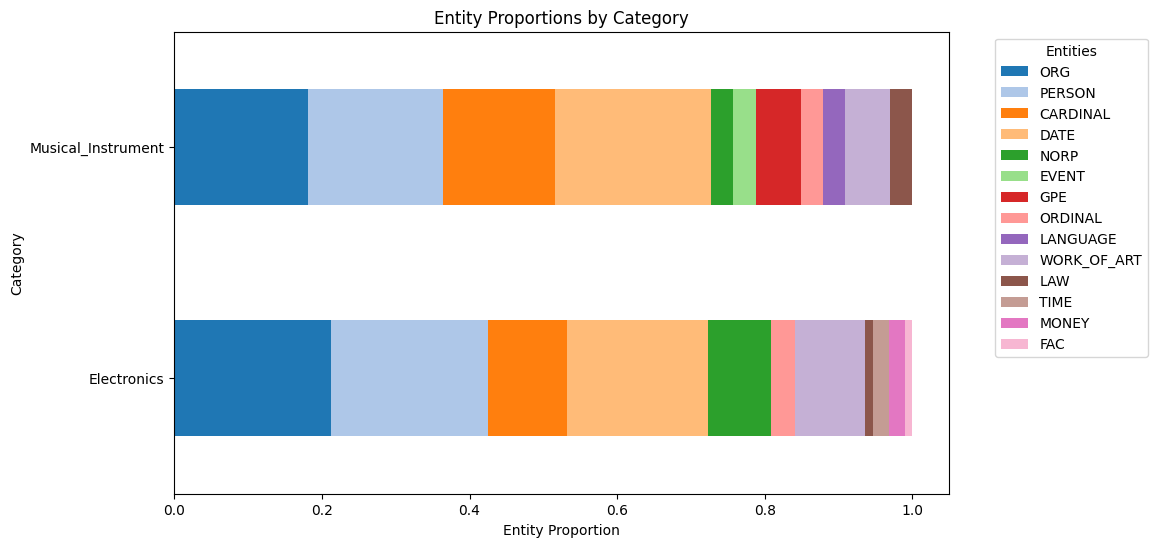

In [99]:
# Example usage:
plot_entity_proportions(df)


### By Star ratings

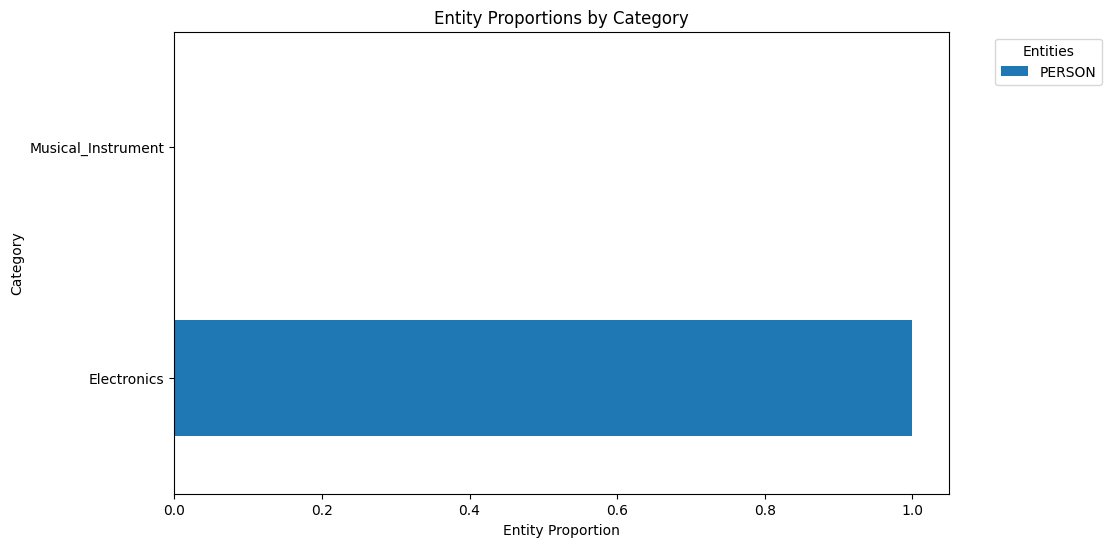

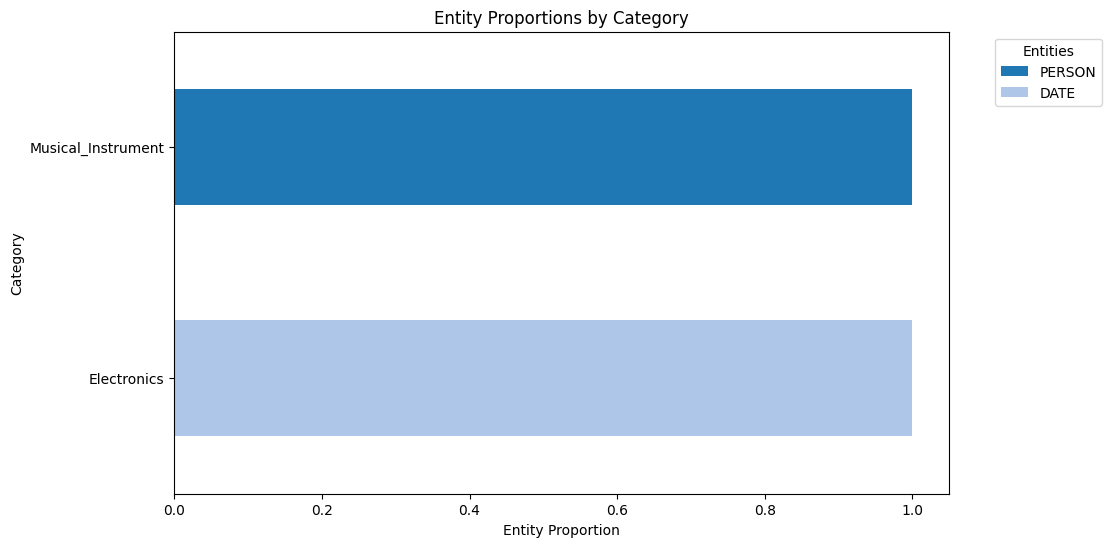

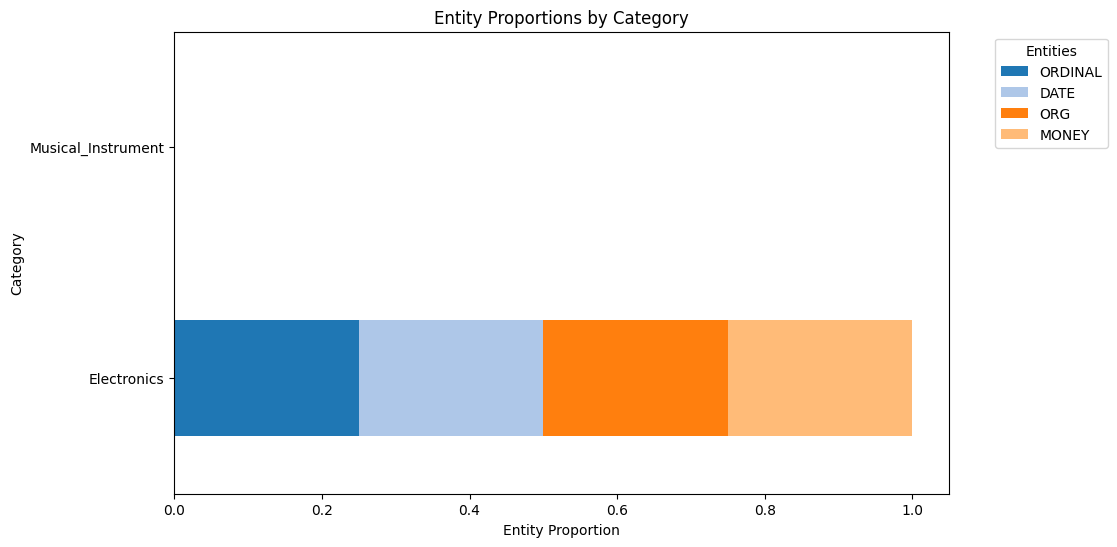

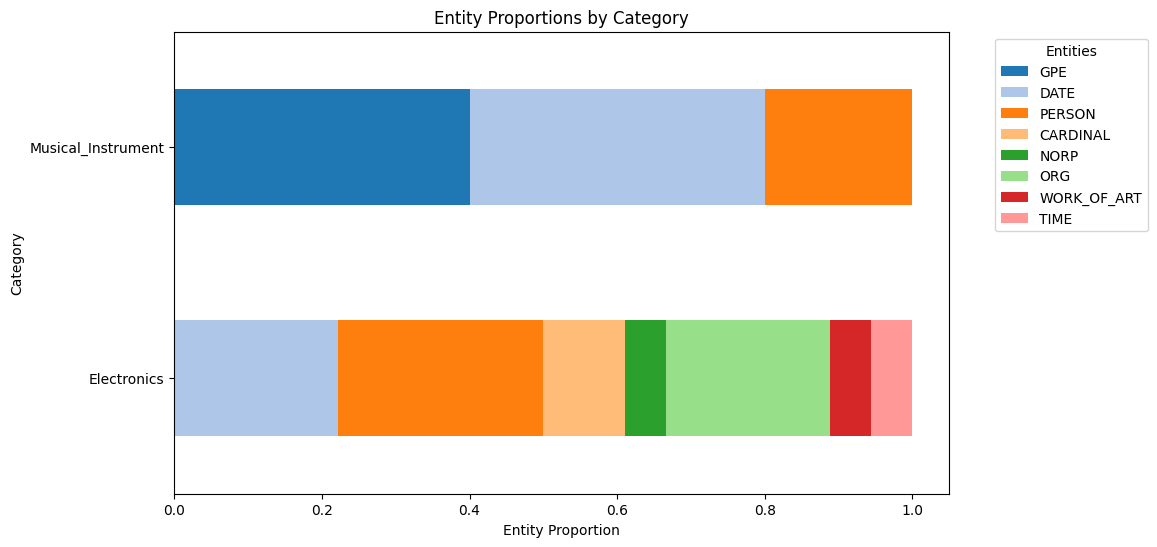

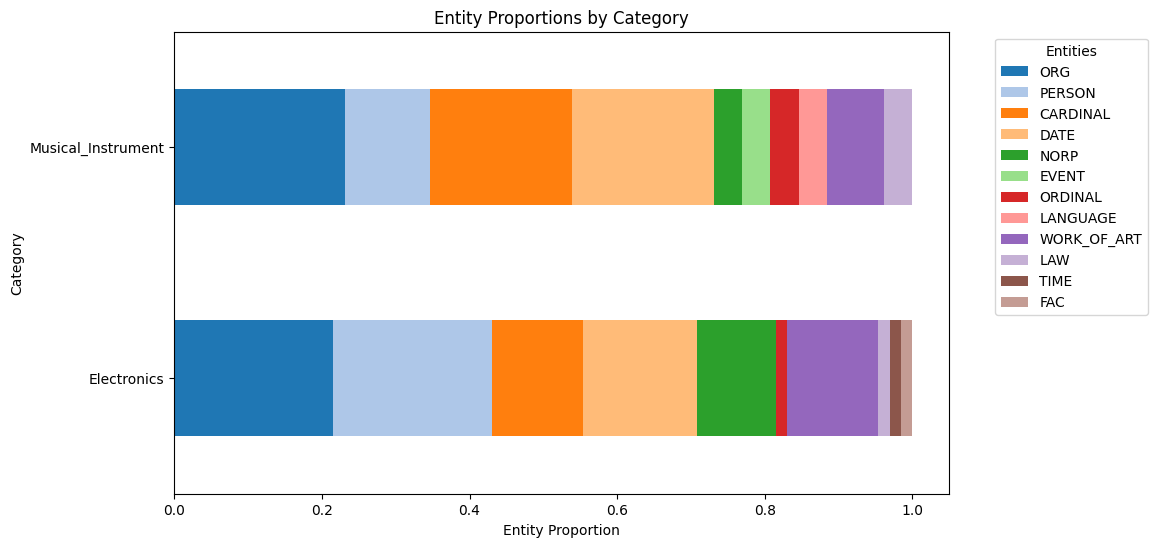

In [100]:
plot_entity_proportions(df[df["overall"] == 1])
plot_entity_proportions(df[df["overall"] == 2])
plot_entity_proportions(df[df["overall"] == 3])
plot_entity_proportions(df[df["overall"] == 4])
plot_entity_proportions(df[df["overall"] == 5])


# Wordcloud

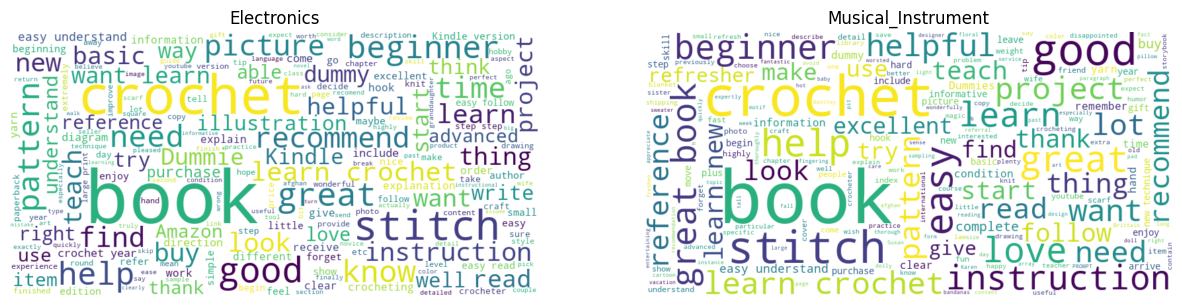

In [101]:
### Final Code

def generate_wordclouds_by_category(df, text_column='reviewText', category_column='category', width=800, height=400, max_font_size=110):
    # Create a dictionary to store word clouds for each category
    wordclouds_by_category = {}

    # Iterate through unique categories
    for category, group_df in df.groupby(category_column):
        # Concatenate all text in the specified column for the current category
        text = ' '.join(group_df[text_column].astype(str))

        # Generate the word cloud for the current category
        wordcloud = WordCloud(width=width, height=height, random_state=21, max_font_size=max_font_size, background_color='white').generate(text)

        # Store the word cloud in the dictionary
        wordclouds_by_category[category] = wordcloud

    # Plot the WordCloud images for each category
    fig, axs = plt.subplots(1, len(wordclouds_by_category), figsize=(15, 5))

    for i, (category, wordcloud) in enumerate(wordclouds_by_category.items()):
        axs[i].imshow(wordcloud, interpolation="bilinear")
        axs[i].set_title(category)
        axs[i].axis('off')

    plt.show()

# Example usage:
# Assuming you have already loaded your data into a DataFrame called df
# If not, replace df with your actual DataFrame variable
generate_wordclouds_by_category(df)

Summarize all review texts to compute Wordcloud.
Tried without lemma and with lemma. Stopwords were removed

In [102]:
def extract_all_reviews(row):
    spacy_obj = nlp(row)
    processed_text = spacy_obj.text
    reviewText_as_list.append(processed_text)


def get_wordcloud(column_data):
    # Clear the previous reviewText_as_list
    global reviewText_as_list
    reviewText_as_list = []

    # Apply the extract_all_reviews function to each row in the specified column
    column_data.apply(extract_all_reviews)

    # Each review as one string
    reviewText_as_string = ' '.join(reviewText_as_list)

    # Tokenize with spaCy
    doc = nlp(reviewText_as_string)

    # Word counts without stopwords removal
    word_counts = Counter([token.text.lower() for token in doc if token.is_alpha])

    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

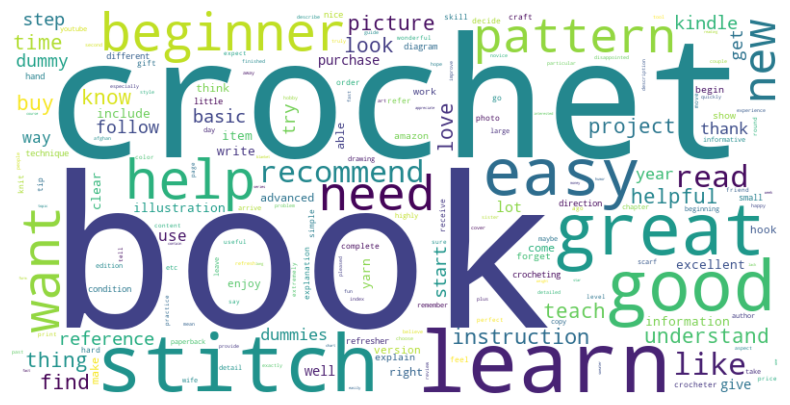

In [103]:
get_wordcloud(df['reviewText'])

# Name Entity Recognition

### Overall Count - Motivation
The goal is to extract, for each product category, the overall count of mentioned entities to analyze various aspects and draw conclusions about the mentioned aspects within different categories. For named entity recognition, the spaCy library is used, which has built-in recognition. There are 18 different entities. To inspect all possible labels, use the following code:
`import spacy
nlp = spacy.load("en_core_web_md")
nlp.get_pipe("ner").labels`

In [104]:
# Aggregating all reviews for one category for further analysis
reviewText_as_list = []

def aggregate_reviews(row):
    spacy_obj = nlp(row["reviewText"])
    processed_text = spacy_obj.text
    reviewText_as_list.append(processed_text)

# Assuming df is your DataFrame
df.apply(aggregate_reviews, axis=1)

# Each review as one string
reviewText_as_string = ' '.join(reviewText_as_list)

doc = nlp(reviewText_as_string)

# Evaluation

In [105]:
def get_entity_counts(doc):
    res_dic = {}

    # Count the occurrences of each entity label
    entity_counts = Counter([ent.label_ for ent in doc.ents])

    # Store the total count for each label
    for label, count in entity_counts.items():
        res_dic[label] = count

    return res_dic

# visualize_counts 
def visualize_counts(dic, specifier = None, rotation = 90):
    # Sort labels and counts in descending order
    labels, counts = zip(*sorted(dic.items(), key=lambda x: x[1], reverse=True))

    # adjust title
    title = 'Named Entity Label Counts'
    if specifier != None:
        title = f'Named Entity Label Count for Star Rating {str(specifier)}' 

    # adjust rotation
    if rotation != 90:
        rotation = rotation

    # Create a bar chart
    plt.bar(labels, counts)
    plt.xlabel('Entity Label')
    plt.xticks(rotation=rotation)
    plt.ylabel('Count')
    plt.title(title)
    plt.show()


# visualize_counts 
def stack_visualize_counts(dic, specifier=None, rotation=0):
    # Sort labels and counts in descending order
    labels, counts = zip(*sorted(dic.items(), key=lambda x: x[1], reverse=True))

    # adjust title
    title = 'Named Entity Label Counts'
    if specifier is not None:
        title = f'Named Entity Label Count for Star Rating {str(specifier)}'

    # Create a stacked horizontal bar chart
    plt.barh(labels, counts)
    plt.xlabel('Count')
    plt.ylabel('Entity Label')
    plt.title(title)
    plt.show()

# Example usage:
# doc = ...  # your Spacy document
# entity_counts = get_entity_counts(doc)
# visualize_counts(entity_counts)



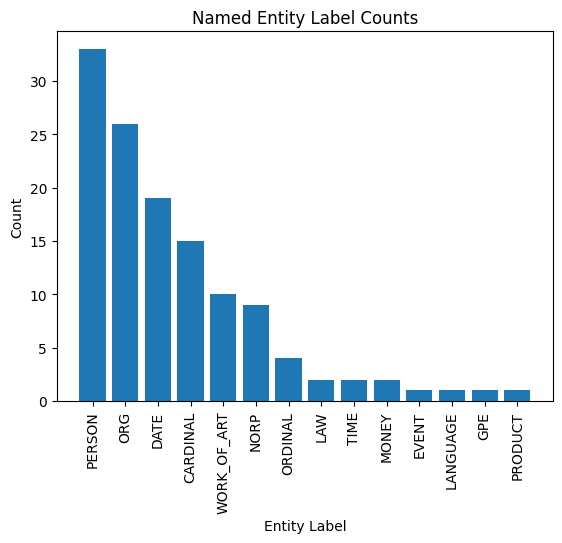

In [106]:
entitiy_counts = get_entity_counts(doc)
visualize_counts(entitiy_counts)


### Differentiate NER between Star Ratings

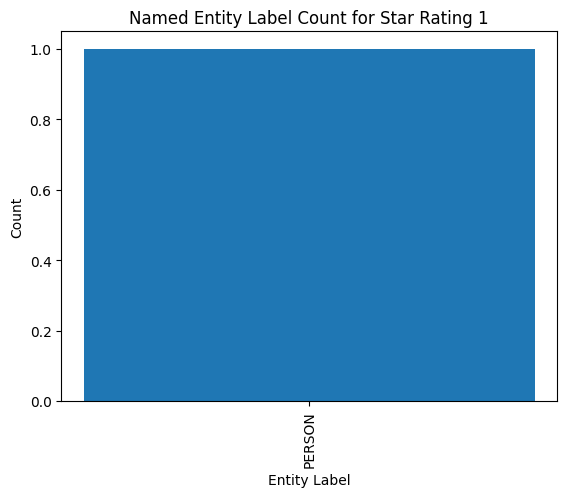

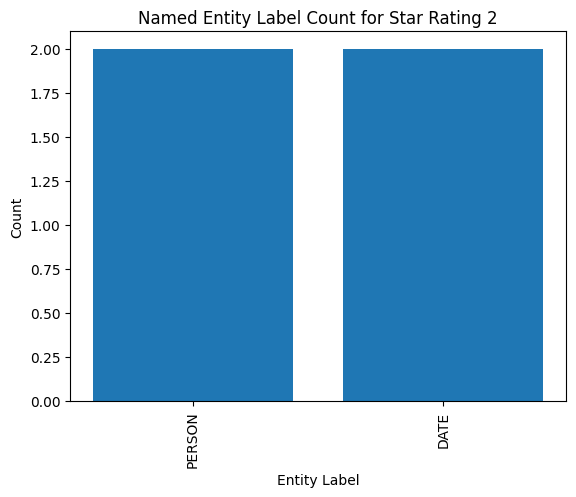

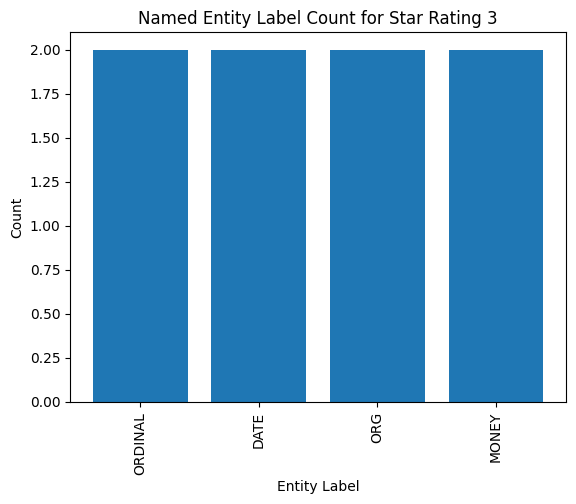

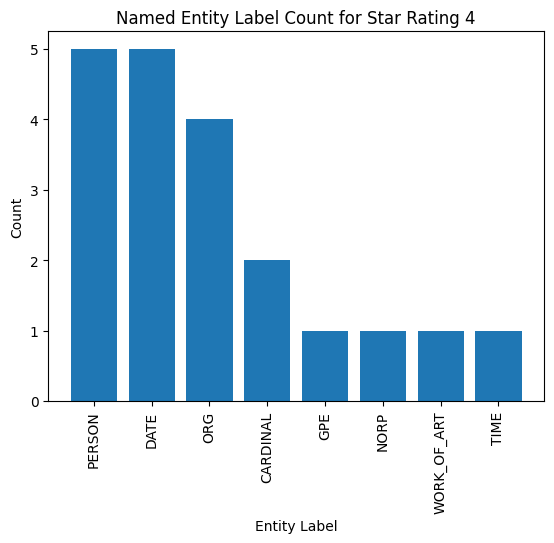

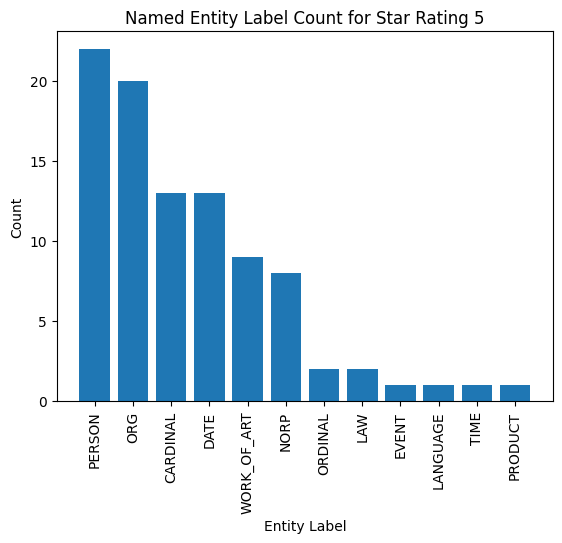

In [107]:
# Assuming df is your DataFrame
def get_review(row):
    spacy_obj = nlp(row["reviewText"])
    return spacy_obj.text

for i in range(1,6):
    
    df_temp = df[df["overall"] == i]

    # Applying the function to create a list of concatenated reviews
    concatenated_reviews_list = df_temp.apply(get_review, axis=1).tolist()

    # Each review as one string
    reviewText_as_string = ' '.join(concatenated_reviews_list)

    # create spaCy object
    doc = nlp(reviewText_as_string)

    # visualize
    visualize_counts(get_entity_counts(doc), str(i))

# Analyze Key Aspects
### Motivation
Our assumption is that nouns and adjectives might carry and reflect the most information about certain aspects of a product. A top-k listing for nouns and adjectives is created to estimate the most important aspect.

In [108]:
def extract_key_aspects(text):
    # Process the text using spaCy
    doc = nlp(text)

    # Extract nouns, adjectives, and verbs as key aspects
    nouns = [token.text.lower() for token in doc if token.pos_ == 'NOUN']
    adjectives = [token.text.lower() for token in doc if token.pos_ == 'ADJ']
    verbs = [token.text.lower() for token in doc if token.pos_ == 'VERB']

    return nouns, adjectives, verbs

def analyze_reviews_from_column(column_data):
    noun_dict = {}
    adj_dict = {}
    verb_dict = {}

    # Extract key aspects from each review in the specified column
    for review in column_data:
        nouns, adjectives, verbs = extract_key_aspects(review)

        # Count the occurrences of each aspect for nouns
        noun_counts = Counter(nouns)
        for noun, count in noun_counts.items():
            if noun in noun_dict:
                noun_dict[noun] += count
            else:
                noun_dict[noun] = count

        # Count the occurrences of each aspect for adjectives
        adjective_counts = Counter(adjectives)
        for adjective, count in adjective_counts.items():
            if adjective in adj_dict:
                adj_dict[adjective] += count
            else:
                adj_dict[adjective] = count

        # Count the occurrences of each aspect for verbs
        verb_counts = Counter(verbs)
        for verb, count in verb_counts.items():
            if verb in verb_dict:
                verb_dict[verb] += count
            else:
                verb_dict[verb] = count

    # Get the most common aspects for nouns, adjectives, and verbs
    most_common_nouns = Counter(noun_dict).most_common(5)
    most_common_adjectives = Counter(adj_dict).most_common(5)
    most_common_verbs = Counter(verb_dict).most_common(5)

    # Return the dictionaries
    return dict(most_common_nouns), dict(most_common_adjectives), dict(most_common_verbs)

In [109]:
# Usage
noun_results, adj_results, verb_results = analyze_reviews_from_column(df['reviewText'])

print("Noun results:", noun_results)
print("Adjective results:", adj_results)
print("Verb results:", verb_results)

Noun results: {'book': 275, 'crochet': 161, 'stitch': 65, 'pattern': 35, 'beginner': 33}
Adjective results: {'great': 56, 'good': 56, 'new': 32, 'easy': 27, 'helpful': 24}
Verb results: {'learn': 82, 'recommend': 32, 'want': 31, 'find': 27, 'understand': 27}


### Evaluation

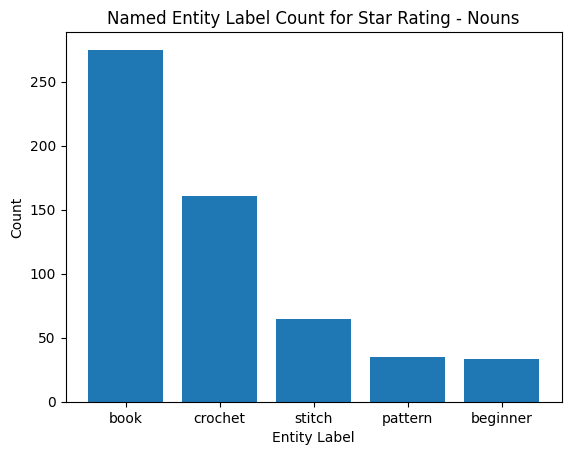

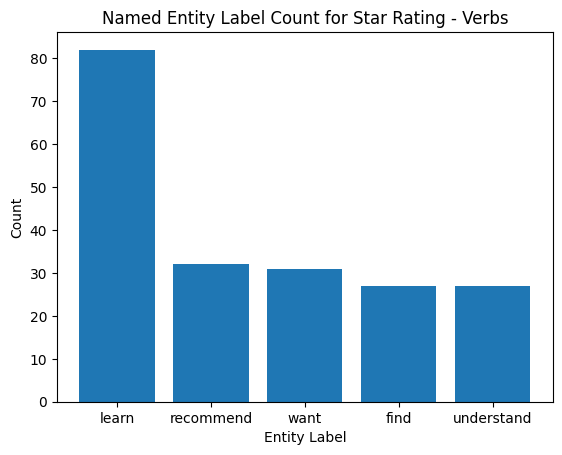

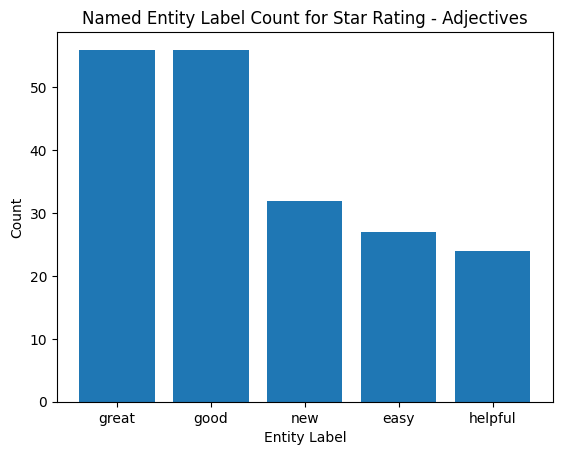

In [110]:
visualize_counts(noun_results, specifier="- Nouns", rotation=0)
visualize_counts(verb_results, specifier="- Verbs", rotation=0)
visualize_counts(adj_results, specifier="- Adjectives", rotation=0)



# Upvoted Reviews

### Mean Number of Words for Reviews vs. Upvoted Reviews

Take top n upvoted reviews instead of threshold

C:\Users\Alexander Lorenz\AppData\Local\Temp\ipykernel_16968\34332627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upvoted_df['reviewText_word_count'] = upvoted_df['reviewText'].apply(lambda x: len(nlp(x)))


Average number of words in of upvoted reviews: 97.00
Average number of words of all reviews: 22.09


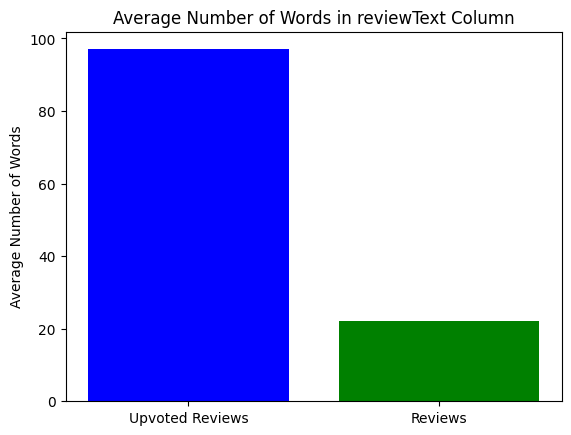

In [111]:
upvoted_df = df[df["vote"] > 10]

upvoted_df['reviewText_word_count'] = upvoted_df['reviewText'].apply(lambda x: len(nlp(x)))
average_word_count_upvoted = upvoted_df['reviewText_word_count'].mean()
print(f"Average number of words in of upvoted reviews: {average_word_count_upvoted:.2f}")



df['reviewText_word_count'] = df['reviewText'].apply(lambda x: len(nlp(x)))
average_word_count = df['reviewText_word_count'].mean()
print(f"Average number of words of all reviews: {average_word_count:.2f}")

# Plotting the averages
labels = ['Upvoted Reviews', 'Reviews']
averages = [average_word_count_upvoted, average_word_count]

plt.bar(labels, averages, color=['blue', 'green'])
plt.ylabel('Average Number of Words')
plt.title('Average Number of Words in reviewText Column')
plt.show()


### Wordcloud and POS

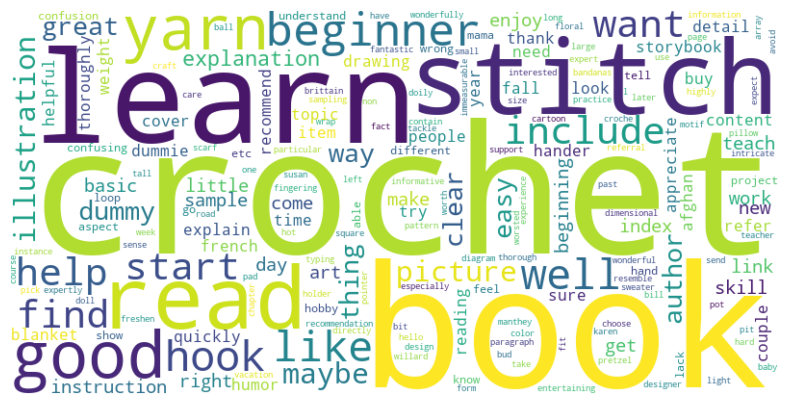

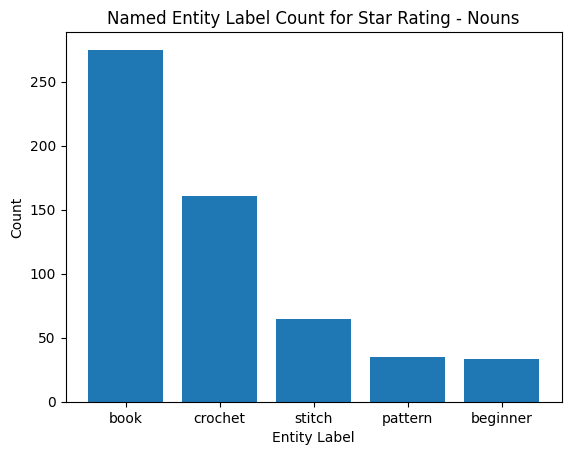

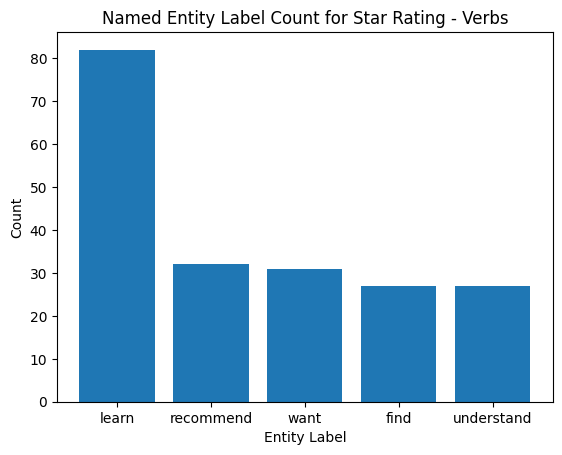

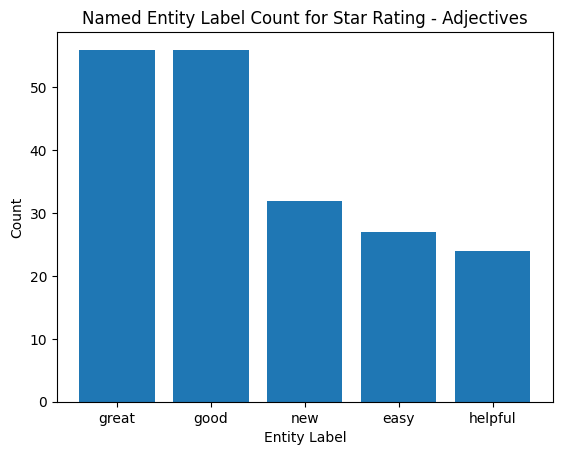

In [112]:
# get upvoted reviews
upvoted_df = df[df["vote"] > 5]

# Wordcloud
get_wordcloud(upvoted_df['reviewText'])

# analyze part of speech
noun_results, adj_results, verb_results = analyze_reviews_from_column(df['reviewText'])
visualize_counts(noun_results, specifier="- Nouns", rotation=0)
visualize_counts(verb_results, specifier="- Verbs", rotation=0)
visualize_counts(adj_results, specifier="- Adjectives", rotation=0)


  Deisenroth, M. P., Faisal, A. A., & Ong, C. S. (2020). Mathematics for machine learning. Cambridge University Press.


### Archive

In [113]:
# extract aspects over each cateogory 
"""
# Example usage
categories = {
    'Electronics': [
        "The camera quality is amazing, but the battery life is disappointing.",
        "The screen resolution is excellent, and the build quality is sturdy."
    ],
    'Clothing': [
        "The fabric feels soft and comfortable.",
        "The stitching on this shirt is terrible."
    ],
    # Add more categories and reviews as needed
}

for category, reviews in categories.items():
    print(f"Analyzing reviews for {category}:")
    analyze_reviews(reviews)
    print()
"""

'\n# Example usage\ncategories = {\n    \'Electronics\': [\n        "The camera quality is amazing, but the battery life is disappointing.",\n        "The screen resolution is excellent, and the build quality is sturdy."\n    ],\n    \'Clothing\': [\n        "The fabric feels soft and comfortable.",\n        "The stitching on this shirt is terrible."\n    ],\n    # Add more categories and reviews as needed\n}\n\nfor category, reviews in categories.items():\n    print(f"Analyzing reviews for {category}:")\n    analyze_reviews(reviews)\n    print()\n'

In [114]:


mod = [i for i in range(1,11) if i%2 == 0]

print(mod)

[2, 4, 6, 8, 10]
